# Introduction to kNN in Python

This is a new classroom activity for **October 11**, based on **slide deck 9**.

Note that you will have another activity due on that day, which has to do with the next slide deck.

## Instructions
- Create a Google Colab file (extension `.ipynb`) that implements any kNN analysis in Python. You may copy parts of all the code in the previous slides if you like.
- Name your file with the date (format: YYYYMMDD), underscore, the last name, and the .ipynb extension (for example, `20221011_jacobmachado.ipynb`)

## Challenge (optional)

The challenge is optional.

Instructions:

- Add another example using a dataset that is not the abalone
data.
- Make sure it is an example of a kNN implementation in
bioinformatics.

## Source

The data can be extracted from https://github.com/adityakumar529/Coursera_Capstone/blob/master/diabetes.csv. Analyses are based on post entitled "KNN Algorithm: When? Why? How?," written by Aditya Kumar and published on May 25, 2020, at Medium ([click here](https://towardsdatascience.com/knn-algorithm-what-when-why-how-41405c16c36f)). All these links were last accessed on October 4, 2022.

In [1]:
# Get some diabetes data
import pandas as pd
url = ("https://raw.githubusercontent.com/adityakumar529/Coursera_Capstone/master/diabetes.csv") # This is also available to you in CANVAS
data = pd.read_csv(url)
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

## Non-zero factors

The dataset contatains datapoints marked as zero. However, there are some factors where the values cannot be zero. `Glucose` values, for example, cannot be 0 for a human. Similarly, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` cannot be zero for a human. Therefore, we will replace some zero values with `NaN` (**Not-a-Number**) before proceeding with our analysis

In [2]:
# There are some factors where the values cannot be zero
import numpy as np
non_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for coloumn in non_zero:
    data[coloumn] = data[coloumn].replace(0,np.NaN)
    mean = int(data[coloumn].mean(skipna = True))
    data[coloumn] = data[coloumn].replace(np.NaN, mean)
    print(data[coloumn])

0      148.0
1       85.0
2      183.0
3       89.0
4      137.0
       ...  
763    101.0
764    122.0
765    121.0
766    126.0
767     93.0
Name: Glucose, Length: 768, dtype: float64
0      72.0
1      66.0
2      64.0
3      66.0
4      40.0
       ... 
763    76.0
764    70.0
765    72.0
766    60.0
767    70.0
Name: BloodPressure, Length: 768, dtype: float64
0      35.0
1      29.0
2      29.0
3      23.0
4      35.0
       ... 
763    48.0
764    27.0
765    23.0
766    29.0
767    31.0
Name: SkinThickness, Length: 768, dtype: float64
0      155.0
1      155.0
2      155.0
3       94.0
4      168.0
       ...  
763    180.0
764    155.0
765    112.0
766    155.0
767    155.0
Name: Insulin, Length: 768, dtype: float64
0      33.6
1      26.6
2      23.3
3      28.1
4      43.1
       ... 
763    32.9
764    36.8
765    26.2
766    30.1
767    30.4
Name: BMI, Length: 768, dtype: float64


## Initial vizualization using Seaborn

Let’s use `seaborn` to plot details of the diabetes data.

[Seaborn](https://seaborn.pydata.org/#) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

For a brief introduction to the ideas behind the library, you can read the [introductory notes](https://seaborn.pydata.org/tutorial/introduction.html) or the [paper](https://joss.theoj.org/papers/10.21105/joss.03021). There are also a number of [tutorials](https://seaborn.pydata.org/tutorial.html) online.

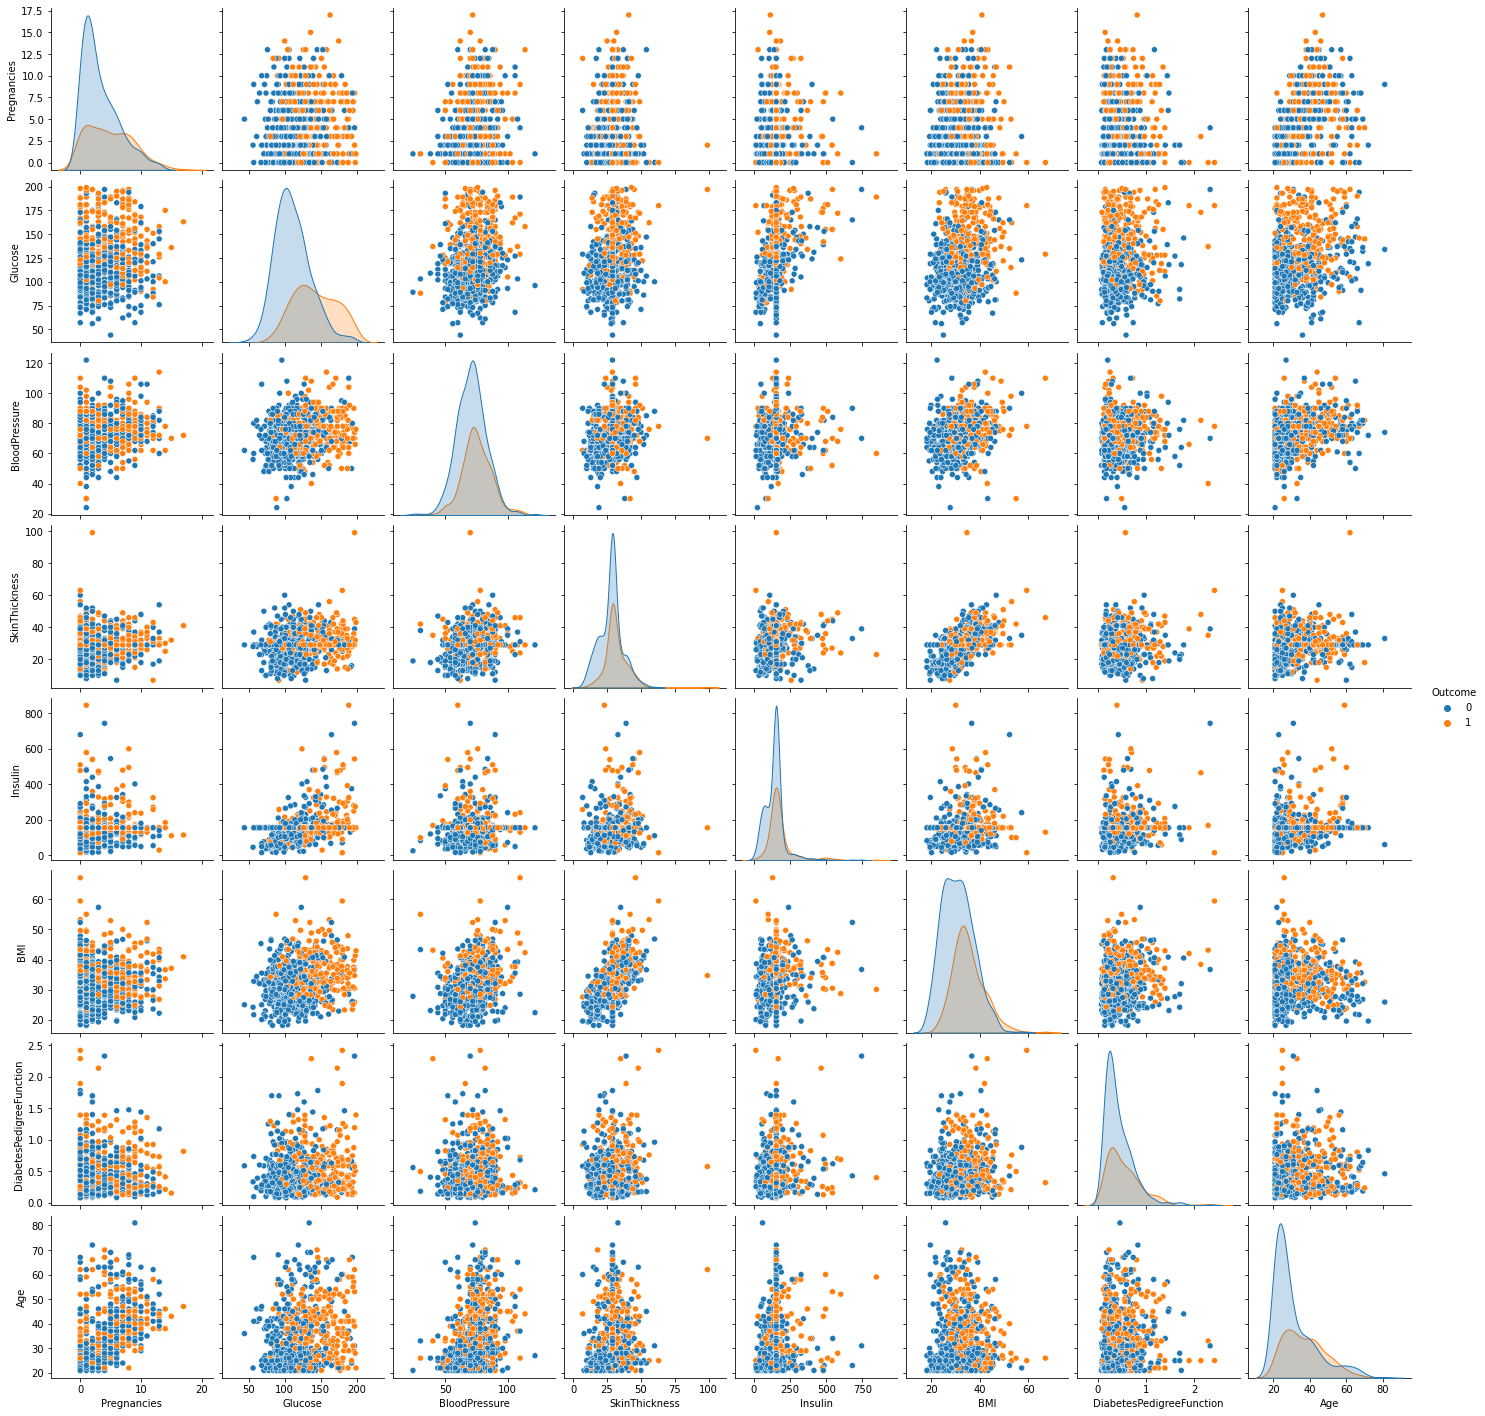

In [3]:
# Let’s plot details of the diabetes data
import seaborn as sns
p=sns.pairplot(data, hue = 'Outcome')

## Splitting the data

We can split the data into training and testing sets using `train_test_split`, from `sklearn.model_selection`. To keep it simple, we are not using a validation set in this example.

In [4]:
# Let us split the data between a training and a testing dataset
from sklearn.model_selection import train_test_split
X =data.iloc[:,0:8]
y =data.iloc[:,8]
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
print("This is how the y_test set looks like:\n{}".format(y_test.head))
print("This is how the X_test set looks like:\n{}".format(X_test.head))

This is how the y_test set looks like:
<bound method NDFrame.head of 680    0
607    0
639    0
638    1
295    0
      ..
526    0
685    0
391    1
654    0
315    0
Name: Outcome, Length: 154, dtype: int64>
This is how the X_test set looks like:
<bound method NDFrame.head of      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
680            2     56.0           56.0           28.0     45.0  24.2   
607            1     92.0           62.0           25.0     41.0  19.5   
639            1    100.0           74.0           12.0     46.0  19.5   
638            7     97.0           76.0           32.0     91.0  40.9   
295            6    151.0           62.0           31.0    120.0  35.5   
..           ...      ...            ...            ...      ...   ...   
526            1     97.0           64.0           19.0     82.0  18.2   
685            2    129.0           74.0           26.0    205.0  33.2   
391            5    166.0           76.0           29.0

## Standardization

`StandardScaler` performs the task of **standardization**. Standardization is often applied when a dataset contains variables that are different in scale.

For example, the dataset will contain an insulin column with values on scale 20–70 and Glucose column with values on scale 80–200. As these two columns are different in scale, they are standardized to have a common scale while building a machine learning model.

In [5]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
print("This is how the X-test set looks like after scaling:\n{}".format(X_test))

This is how the X-test set looks like after scaling:
[[-0.57822139 -2.19214158 -1.36006628 ... -1.20679699 -0.42680996
  -0.97337087]
 [-0.86994525 -0.99031864 -0.87152453 ... -1.90131174  0.01214391
  -0.72073607]
 [-0.86994525 -0.72324687  0.10555897 ... -1.90131174 -0.96233369
  -0.46810128]
 ...
 [ 0.29695018  1.4800952   0.26840622 ...  1.97023856 -0.40339909
  -0.55231288]
 [-0.86994525 -0.52294305 -0.22013553 ...  0.27089396 -0.98281821
  -0.97337087]
 [-0.57822139 -0.32263922 -0.38298278 ...  0.25611705 -0.47655807
  -0.63652448]]


## Initial optimization

We are going to use `GridSearchCV` to find the best value of *k* and the best weighting strategy for a kNN classification analyses with `KNeighborsClassifier`.

`GridSearchCV` is a technique to search through the best parameter values from the given set of the grid of parameters. `GridSearchCV` tries all the combinations of the values passed in the dictionary and evaluates the model for each combination using the **Cross-Validation** (CV) method. Hence after using this function we get accuracy/loss for every combination of hyperparameters and we can choose the one with the best performance.

Note that the model and the parameters are required to be fed into `GridSearchCV`. After that, the best parameter values are extracted and a new model is then calculated using the best parameter values found this way. The predictions are made after that.

In [6]:
# Optimizing kNN with scikit-learn and GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
parameters = {"n_neighbors": range(1, 50), "weights": ["uniform", "distance"],}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)
best_parameters = gridsearch.best_params_
best_k = best_parameters["n_neighbors"]
best_weights = best_parameters["weights"]
print("The best value of k in {}".format(best_k))
print("The best weigh function is {}".format(best_weights))
test_preds_grid = gridsearch.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
print("The RMSE is {}".format(test_rmse))


The best value of k in 17
The best weigh function is uniform
The RMSE is 0.496742636335202


## Bagging

Now that the initial optimization is complete, we improve the model with **bagging**.

Bagging, also known as **Bootstrap aggregating**, is an ensemble learning technique that helps to improve the performance and accuracy of machine learning algorithms. It is used to deal with bias-variance trade-offs and reduces the variance of a prediction model.

In bagging, a random sample of data in a training set is selected with replacement—meaning that the individual data points can be chosen more than once. After several data samples are generated, these weak models are then trained independently, and depending on the type of task—regression or classification, for example—the average or majority of those predictions yield a more accurate estimate.

[Click here](https://www.ibm.com/cloud/learn/bagging) to read a bit more about bagging.

### Note about bagging and random forest

The **random forest** algorithm is considered an extension of the bagging method, using both bagging and feature randomness to create an uncorrelated forest of decision trees. [Click here](https://www.section.io/engineering-education/introduction-to-random-forest-in-machine-learning/) to read more about random forest.

In [7]:
# Create the KNeighborsRegressor with the best choices for k and weights that you got from GridSearchCV
bagged_knn = KNeighborsClassifier(n_neighbors = best_k, weights = best_weights, p = 2, metric='euclidean')

In [8]:
# Import the BaggingClassifier class from scikit-learn and create a new instance with 100 estimators using the bagged_knn model
from sklearn.ensemble import BaggingClassifier
bagging_model = BaggingClassifier(bagged_knn, n_estimators=100)

In [9]:
# We will need to 'fit' the 'model' in preparation for the next steps
bagging_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(metric='euclidean',
                                                      n_neighbors=17),
                  n_estimators=100)

In [10]:
# Make a prediction and calculate the RMSE after bagging
test_preds_grid = bagging_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
print("This is the RMSE: {}".format(test_rmse))

This is the RMSE: 0.48349377841522817


## Accuracy and F-1 Score

We have an array of data, but we need to evaluate our model to check the accuracy. Do start working on that, we can produce a confusion matrix.

In [11]:
# Initial predictions
y_pred =  bagging_model.predict(X_test)
print("Here are some predicitons made after bagging:\n{}".format(y_pred))
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Here is the confusion matrix:\n{}".format(cm))

Here are some predicitons made after bagging:
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1
 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0
 1 0 0 1 0 0]
Here is the confusion matrix:
[[86 14]
 [22 32]]


We have a confusion matrix where the diagonal with 87 and 29 shows the correct value and 13, 25 shows the prediction that we missed. Next, we will check the **F1-score**.

### F-1 score

F1-score is one of the most important evaluation metrics in machine learning. It elegantly sums up the predictive performance of a model by combining two otherwise competing metrics:

- **Precision**: Of all positive predictions, how many are really positive?
- **Recall**: Of all real positive cases, how many are predicted positive?

Precision measures the extent of error caused by **False Positives** (**FPs**) whereas recall measures the extent of error caused by **False Negatives** (**FNs**).

 F1-score is the harmonic mean of precision and recall. The higher the precision and recall, the higher the F1-score. F1-score ranges between 0 and 1. The closer it is to 1, the better the model.

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print("The f1 score is {}".format(f1_score(y_test,y_pred)))
print("The accuracy score is {}".format(accuracy_score(y_test,y_pred)))

The f1 score is 0.6399999999999999
The accuracy score is 0.7662337662337663


We have f1 score as ~0.60 and an accuracy score of ~0.75. Now we plot the graph for the actual data and our predicted value.

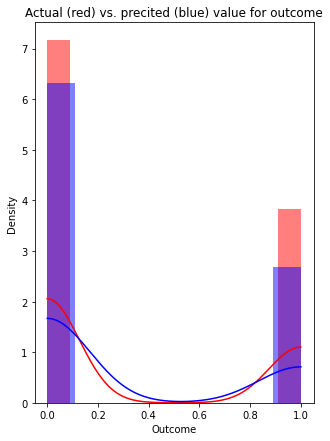

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 7))
ax = sns.histplot(data['Outcome'], color = "r", kde = True, stat = "density", linewidth = 0)
sns.histplot(y_pred, color = "b", ax = ax, kde = True, stat = "density", linewidth = 0)
plt.title('Actual (red) vs. precited (blue) value for outcome')
plt.show()
plt.close()

## Interpretting the final results

To judge the kNN model above, you should start by judging the plot above while 
keeping in mind the concepts of density curves and F-1 scores.

## More on density curves

Our last plot is an histogram with fitted density curves.

A **density curve** is a curve on a graph that represents the distribution of values in a dataset. It's useful for three reasons:

1. A density curve gives us a good idea of the **shape** of a distribution, including whether or not a distribution has one or more **peaks** of frequently occurring values and whether or not the distribution is skewed to the left or the right.
2. A density curve lets us visually see where the **mean** and the **median** of a distribution are located.
3. A density curve lets us visually see what percentage of observations in a dataset fall between different values.

The most famous density curve is the bell-shaped curve that represents the normal distribution.

Density curves come in all shapes and sizes and they allow us to gain a quick visual understanding of the distribution of values in a given dataset. In particular, they’re useful for helping us visualize:

### Skewness

**Skewness** is a way to describe the symmetry of a distribution. Density curves allow us to quickly see whether or not a graph is left skewed, right skewed, or has no skew. For example, the traditional, bell-shaped, normal distribution has no skew.

### The location of the mean and median

Depending on the skewness of a density curve, we can quickly know whether the **mean** or **median** is larger in a given distribution. In particular:

- If a density curve is **left** skewed, then $\mbox{mean} < \mbox{median}$
- If a density curve is **right** skewed, then $\mbox{mean} > \mbox{median}$
- If a density curve has no skew, then $\mbox{mean} = \mbox{median}$

This is easier to observe in unimodal distributions (see below).

### Number of peaks

Density curves also allow us to quickly see how many **peaks** there are in a given distribution. In our last plot, the distributions has to have two pieaks as results can only ne 0 or 1. So we would describe those distributions as a special **bimodal** (special because no other values other than 0 or 1 are observed). 

However, some distributions can have onetwo peak which we call **unimodal** distributions. And in rare cases we can also have **multimodal** distributions that have more than two peaks.

## More on F-1 scores

**F1-score** is one of the most important evaluation metrics in machine learning. It elegantly sums up the predictive performance of a model by combining two otherwise competing metrics — **precision** and **recall**.

### Errors type I and II

To understand precision and recall, we must first understand the different between type I and type II error.

Imagine that you decide to get tested for COVID-19 based on mild symptoms. There are two errors that could potentially occur:

- **Type I error** (a.k.a. **False Positive**): the test result says you have coronavirus, but you actually don't.
- **Type II error** (a.k.a. **False Negative**): the test result says you don't have coronavirus, but you actually do.

The Type I and Type II error rates influence each other. That’s because the **significance level** (the Type I error rate) affects **statistical power**, which is inversely related to the Type II error rate.

This means there’s an important tradeoff between Type I and Type II errors:

- Setting a lower significance level decreases a Type I error risk, but increases a Type II error risk.
- Increasing the power of a test decreases a Type II error risk, but increases a Type I error risk.

### Precision

Precision asks how many of the positive predictions are really positive.

$\mbox{Precision} = \frac{\mbox{True Positives}}{\mbox{True Positives} + \mbox{False Positives}}$

### Recall

Recall (a.k.a. **sensitivity**) asks how many of the positive predictions will be made from all positive cases.

$\mbox{Recall} = \frac{\mbox{True Positives}}{\mbox{True Positives} + \mbox{False Negatives}}$